<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

**Цель проекта**

Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Необходимо обучить модели классифицировать комментарии на позитивные и негативные. Построить модели со значением метрики качества *F1* не меньше 0.75. 

**Ход выполнения**

1. Анализ и подготовка данных.
2. Обучение моделей с различными гиперпараметрами, выбор лучшей на валидационной выборке. Тестирование моделей.
3. Выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка данных

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import re

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve, roc_curve

from nltk.corpus import stopwords, wordnet
import nltk
from nltk.stem import WordNetLemmatizer 

try:
    from catboost import CatBoostClassifier, Pool
except:
    !pip install catboost
    from catboost import CatBoostClassifier, Pool

     |████████████████████████████████| 22.0 MB 2.7 MB/s eta 0:00:011     |█████████████████████████████▊  | 20.4 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 3.8 MB/s eta 0:00:01


In [16]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elenamarchenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/elenamarchenko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/elenamarchenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/elenamarchenko/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/elenamarchenko/nltk_data...


True

In [11]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=False)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=False)

In [12]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Датафрейм содержит текст комментариев и целевой признак тонкичности/нетоксичности для 159571 объекта исследования. Проверка на дубликаты не нужна, пропуски в данных отсутствуют. Так же необходимо:

- перейти к векторному представлению слов;
- очистить тексты от знаков препинания и лишних символов.

In [6]:
df.describe()

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Согласно данным, 90% комментариев имеют тип "0" («отрицательный»). Таким образом, работа будет производиться с несбалансированными классами.

In [13]:
df['text'] = df['text'].str.lower().values

In [14]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [17]:
w_n = WordNetLemmatizer()
word = 'heros'
print(w_n.lemmatize(word, get_wordnet_pos(word)))

hero


In [21]:
def lemmatizer(text):
    lemm_list = nltk.word_tokenize(text)
    lemm_text = " ".join([w_n.lemmatize(w, get_wordnet_pos(w)) for w in lemm_list])
    return lemm_text

def clear_text(text):
    re_text = re.sub(r'[^a-z]', " ", text)
    clear_text = " ".join(re_text.split())
    
    return clear_text

In [22]:
%%time
df['text_lemm'] = df['text'].apply(lambda t: lemmatizer(clear_text(t)))

CPU times: user 15min 27s, sys: 52.9 s, total: 16min 19s
Wall time: 16min 20s


In [12]:
df.head(3)

,text,toxic,text_lemm
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not try to edit war it s ju...


In [13]:
df.duplicated().sum()

45

In [14]:
df = df.drop_duplicates()

*Вывод*

На данном этапе мы ознакомились с данными, кроме того:

- тексты очищены от ненужных символов
- создан лемматизированный столбец `text_lemm`
- удалены дубликаты

## Обучение моделей

In [15]:
stop_words = set(stopwords.words('english'))

Метрика $f1$ будет показателем качества моделирования, ее значения должно быть не менее 0,75.

Разобьем данный в соотношении 3:2 для дальнейшего обучения:

In [16]:
train, test = train_test_split(df, test_size= 0.4, random_state = 147)

In [17]:
train.shape, test.shape

((95715, 3), (63811, 3))

In [18]:
corpus = train['text_lemm'].values

In [19]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

In [20]:
tf_idf = count_tf_idf.fit_transform(corpus)

In [21]:
features_train = tf_idf
target_train = train['toxic']

In [22]:
features_test = count_tf_idf.transform(test['text_lemm'])
target_test = test['toxic']

Для записи результатов моделирования создам таблицу:

In [23]:
models = pd.DataFrame(columns = ['parameters', 'f1_train', 'f1_test'])

In [24]:
predictions = pd.DataFrame(columns = ['y_true'], data= test['toxic'].values)

In [25]:
def model_metrics(df, model_name: str, f1_train: float, f1_test: float, parameters: np.array):
    
    df.loc[model_name, 'parameters'] = parameters
    df.loc[model_name, 'f1_train'] = round(f1_train, 5)
    df.loc[model_name, 'f1_test'] = round(f1_test, 5)

**CatBoostClassifier**

In [26]:
text_feat = ['text_lemm']
features = ['text_lemm']
target = ['toxic']

In [27]:
train_data = Pool(data=train[features],
                  label=train[target],
                  text_features=text_feat
                 )

In [28]:
test_data = Pool(data=test[features],
                  label=test[target],
                  text_features=text_feat
                 )

In [29]:
%%time
params=  {'text_features': text_feat,
          'eval_metric': 'F1',
          'learning_rate': 0.15,
          'l2_leaf_reg': 5,
          'random_seed': 147,
          'verbose': 500
         }
cat_model = CatBoostClassifier(**params)
cat_model.fit(train_data)

0:	learn: 0.7078581	total: 300ms	remaining: 4m 59s
500:	learn: 0.8267983	total: 1m 11s	remaining: 1m 11s
999:	learn: 0.8598290	total: 2m 23s	remaining: 0us
Wall time: 2min 27s


In [30]:
predictions['cat_pred'] = cat_model.predict(test_data)

In [31]:
cat_train = f1_score(train['toxic'], cat_model.predict(train_data))
cat_test = f1_score(test['toxic'], predictions['cat_pred'])

In [32]:
print('Оценка F1 на тренировочных данных:', cat_train)
print('Оценка F1 на тестовых данных:', cat_test)

Оценка F1 на тренировочных данных: 0.8824667071890369
Оценка F1 на тестовых данных: 0.7913918205804749


In [33]:
model_metrics(models, 'CatBoostClassifier', cat_train, cat_test, [params])

In [34]:
#%%time
#grid = {'text_features': [text_feat],
#        'eval_metric': ['F1'],
#        'learning_rate': [0.15, 0.3],
#        'random_seed': [147],
#        'l2_leaf_reg': [3, 5],
#        'verbose': [500] 
#       }
#
#catboost = GridSearchCV(CatBoostClassifier(), grid, scoring = 'f1', cv=3)
#catboost.fit(train[features], train[target])

**LogisticRegression**

In [36]:
%%time
log_reg = LogisticRegression()
params = {'C':  range(5,11,2),
          'solver': ['newton-cg', 'sag', 'liblinear'],
          'max_iter': range(50, 151, 50),
          'random_state': [147]
         }
log_model = GridSearchCV(log_reg, params, scoring= 'f1', cv=5)
log_model.fit(features_train, target_train)
print('Гиперпараметры модели:', log_model.best_params_)
print('Оценка F1 на тренировочных данных:', log_model.best_score_)

Гиперпараметры модели: {'C': 9, 'max_iter': 50, 'random_state': 147, 'solver': 'newton-cg'}
Оценка F1 на тренировочных данных: 0.7549209037742493
Wall time: 3min 37s


In [37]:
predictions['log_pred'] = log_model.predict(features_test)

In [38]:
log_test = f1_score(target_test, predictions['log_pred'])
print('Оценка F1 на тестовых данных:', log_test)

Оценка F1 на тестовых данных: 0.7654977278573265


In [39]:
model_metrics(models, 'LogisticRegression', log_model.best_score_, log_test, [log_model.best_params_])

**LGBMClassifier**

In [40]:
%%time
lgbm = LGBMClassifier()
params= {'n_estimators': range(50, 210, 50),
        'learning_rate': [0.1, 0.5, 0.8],
         'objective': ['binary'], 
         'random_state': [147]
        }

lgbm_model = RandomizedSearchCV(lgbm, params, scoring= 'f1', cv=5)
lgbm_model.fit(features_train, target_train)
print('Гиперпараметры модели:', lgbm_model.best_params_)
print('Оценка F1 на тренировочных данных:', lgbm_model.best_score_)

Гиперпараметры модели: {'random_state': 147, 'objective': 'binary', 'n_estimators': 100, 'learning_rate': 0.5}
Оценка F1 на тренировочных данных: 0.7569490723274969
Wall time: 9min 45s


In [41]:
predictions['lgbm_pred'] = lgbm_model.predict(features_test)

In [42]:
lgbm_test = f1_score(target_test, predictions['lgbm_pred'])
print('Оценка F1 на тестовых данных:', lgbm_test)

Оценка F1 на тестовых данных: 0.7628968253968254


In [43]:
model_metrics(models, 'LGBMClassifier', lgbm_model.best_score_, lgbm_test, [lgbm_model.best_params_])

**XGBClassifier**

In [44]:
%%time
xgb = XGBClassifier()
params= {'booster': ['dart', 'gbtree'],
         'eta': [0.3, 1],
         'gamma': [2, 4],
         'objective': ['reg:logistic'], 
         'use_label_encoder': [False],
         'verbosity': [0],
         'random_state': [147]
        }

xgb_model = GridSearchCV(xgb, params, scoring= 'f1', cv=3)
xgb_model.fit(features_train, target_train)
print('Гиперпараметры модели:', xgb_model.best_params_)
print('Оценка F1 на тренировочных данных:', xgb_model.best_score_)

Гиперпараметры модели: {'booster': 'dart', 'eta': 1, 'gamma': 4, 'objective': 'reg:logistic', 'random_state': 147, 'use_label_encoder': False, 'verbosity': 0}
Оценка F1 на тренировочных данных: 0.7344688244116249
Wall time: 14min 2s


In [45]:
predictions['xgb_pred'] = xgb_model.predict(features_test)

In [46]:
xgb_test = f1_score(target_test, predictions['xgb_pred'])
print('Оценка F1 на тестовых данных:', xgb_test)

Оценка F1 на тестовых данных: 0.7418550398198053


In [47]:
model_metrics(models, 'XGBClassifier', xgb_model.best_score_, xgb_test, [xgb_model.best_params_])

**DummyClassifier**

In [48]:
dummy_clf= DummyClassifier(strategy = 'uniform') 
dummy_train_score = cross_val_score(dummy_clf, features_train, target_train, scoring='f1', cv=5).mean()
dummy_test_score = cross_val_score(dummy_clf, features_test, target_test, scoring='f1', cv=5).mean()
print('Оценка F1 на тренировочных данных:', dummy_train_score)
print('Оценка F1 на тестовых данных:', dummy_test_score)

Оценка F1 на тренировочных данных: 0.16781455323812605
Оценка F1 на тестовых данных: 0.16850567463299576


In [49]:
model_metrics(models, 'DummyClassifier', dummy_train_score, dummy_test_score, ['uniform'])

In [50]:
models

,parameters,f1_train,f1_test
CatBoostClassifier,"[{'text_features': ['text_lemm'], 'eval_metric...",0.88247,0.79139
LogisticRegression,"[{'C': 9, 'max_iter': 50, 'random_state': 147,...",0.75492,0.7655
LGBMClassifier,"[{'random_state': 147, 'objective': 'binary', ...",0.75695,0.7629
XGBClassifier,"[{'booster': 'dart', 'eta': 1, 'gamma': 4, 'ob...",0.73447,0.74186
DummyClassifier,[uniform],0.16781,0.16851


**Выводы**

На данном этапе были рассмотрены несколько моделей. Результаты моделирования записаны в датафрейм. 

Далее рассмотрим какая из выбранных моделей лучше всего показала себя на тренировочных и тестовых данных.

## Выводы

Рассмотрим предсказанные значения:

In [51]:
predictions.describe()

,y_true,cat_pred,log_pred,lgbm_pred,xgb_pred
count,63811.000000,63811.000000,63811.000000,63811.000000,63811.000000
mean,0.103681,0.086380,0.079093,0.085879,0.091128
std,0.304849,0.280927,0.269886,0.280187,0.287794
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


Как видно из предсказаний, модель *XGBClassifier* имеет наибольшую долю "1" из всех моделей, но, судя по низкому значению метрики $F1$, проставлены они не всегда верно. Модель сработала неточно.

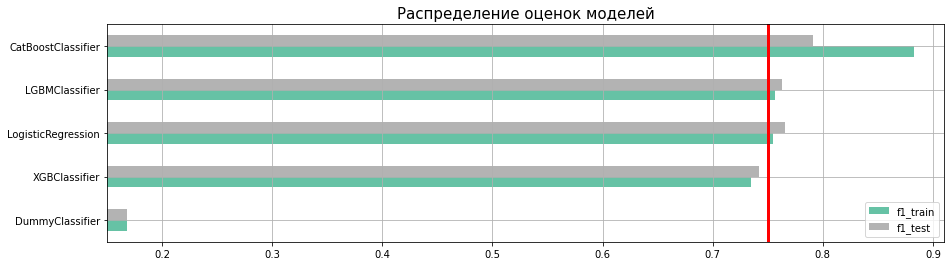

In [52]:
score = models.sort_values(by='f1_train', ascending=True).plot.barh(
    grid=True, xlim=(0.15,0.91), cmap='Set2', figsize=(15, 4))
score.set_title('Распределение оценок моделей', fontsize= 15)
score.axvline(x = 0.75, c='red', lw=3)
plt.legend(loc='lower right')

Итак, по итогам моделирования можно сделать следующие выводы:

- модель *XGBClassifier* не преодолела порог 0,75. 
- Из всех моделей лучше всего на тренировочных и тестовых данных показала себя - модель *CatBoostClassifier* со значениями метрики $F1$ 0,88 и 0,79 соответственно.

Построим кривые *Precision-Recall* и *Roc* для визуализации результатов предсказаний:

In [53]:
def pr_roc(model, x_test, y_test):
    proba_test = model.predict_proba(x_test)
    proba_one_test = proba_test[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, proba_one_test)
    fpr, tpr, thresholds = roc_curve(y_test, proba_one_test)
        
    _, ax = plt.subplots(1, 2, figsize=(15,7))
    ax[0].plot(recall, precision)
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Кривая P-R')
    
    ax[1].plot(fpr, tpr)
    ax[1].plot([0, 1], [0, 1], linestyle='--')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC-кривая")
    plt.suptitle("Метрики PR и ROC для модели классификации", fontsize=15)
    plt.show()    

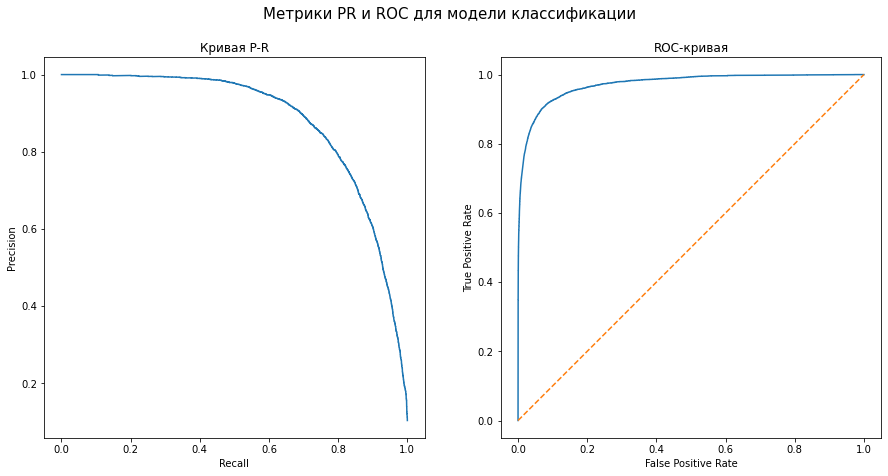

0.6600087983199427

In [54]:
pr_roc(cat_model, test[features], test[target])
average_precision_score(predictions['y_true'],predictions['cat_pred'])

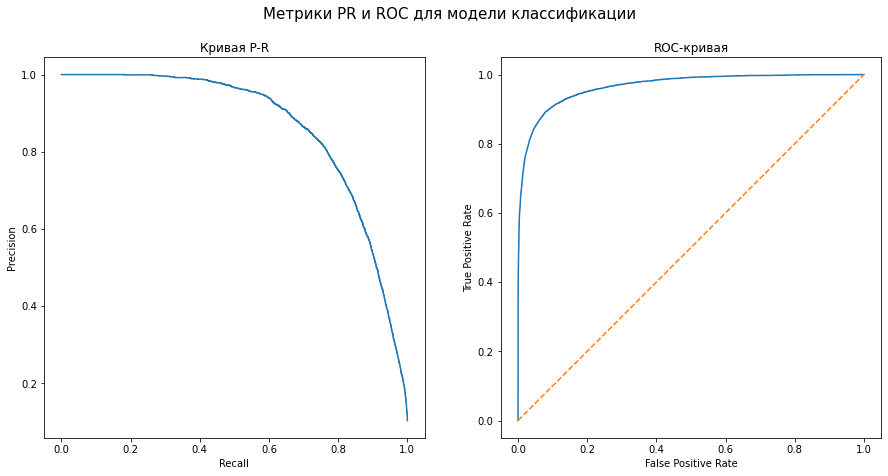

0.6305118902878154

In [55]:
pr_roc(log_model, features_test, target_test)
average_precision_score(predictions['y_true'],predictions['log_pred'])

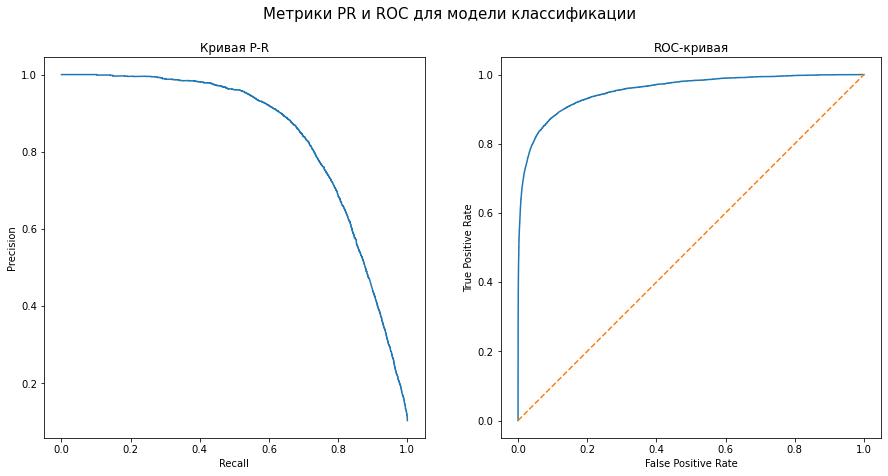

0.6185645426282558

In [56]:
pr_roc(lgbm_model, features_test, target_test)
average_precision_score(predictions['y_true'],predictions['lgbm_pred'])

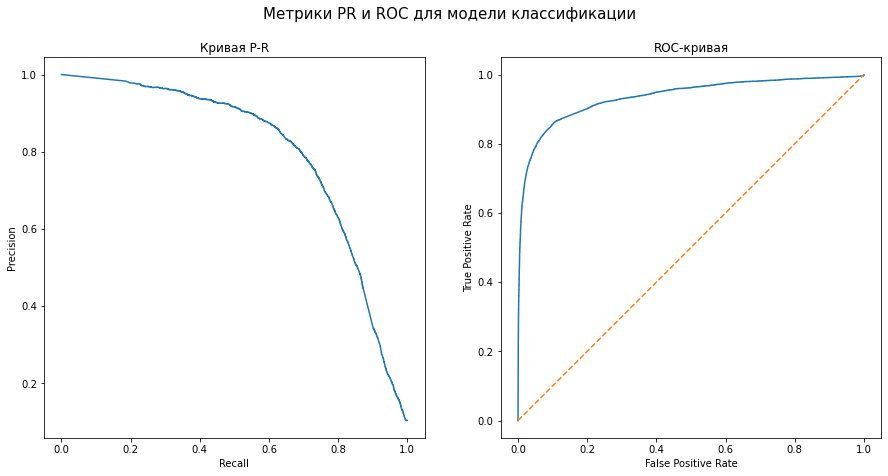

0.584064367121085

In [57]:
pr_roc(xgb_model, features_test, target_test)
average_precision_score(predictions['y_true'],predictions['xgb_pred'])

Для *XGBClassifier* метрика $average-precision-score$ приняла значение 0,59. На графике полноты и точности можно заметить, что модель плохо работает на несбалансированной выборке.

Высокое положение кривой $roc$ подтверждает выводы о том, что лучше всего комментарии класифицирует модель *CatBoostClassifier*. 

**Общий вывод**

Проведена работа по построению моделей классификации для поиска позитивных и негативных комментариев для последующей модерации токсичных комментариев.

В ходе исследовательского анализа данных:

* тексты были очищены от знаков препинания. ненужных символов;
* проведена лемматизация
* удалены дубликаты.

На этапе машинного обучения были использованы модели LogisticRegression, LGBMClassifier, XGBClassifier и CatBoostClassifier. По результатам вычисления получено, что:

- относительно метрик $F1$ и $roc$ лучше всего показала себя модель *CatBoost*;
- модель *XGBClassifier* не прошла порог в 0,75 и хуже всех справилась с классификацией.